# 超参数优化 - 网格优化方法

In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re, pip, conda

In [3]:
for package in [sklearn,mlp,np,pd,sns,pip,conda]:
    print(re.findall("([^']*)",str(package))[2],package.__version__)

sklearn 1.0.1
matplotlib 3.4.3
numpy 1.20.3
pandas 1.3.4
seaborn 0.11.2
pip 21.3.1
conda 4.10.3


In [ ]:
#pip install --upgrade scikit-learn
#conda update scikit-learn

**目录**

一 超参数优化与枚举网格的理论极限<br>
二 随机网格搜索RandomSearchCV<br>
&emsp; 1 随机网格搜索的基本原理<br>
&emsp; 2 随机网格搜索实现<br>
&emsp; 3 随机网格的理论极限<br>
三 Halving网格搜索HalvingSearchCV<br>
&emsp; 1 对半网格搜索的基本流程<br>
&emsp; 2 对半网格搜索的实现<br>
&emsp; 3 对半随机网格搜索<br>
四 【加餐】AutoML前沿进展<br>
&emsp; 1 自动化第三方框架<br>
&emsp; 2 AutoML三大成熟研究领域<br>
&emsp; 3 AutoML的新兴研究

# 一 超参数优化与枚举网格的理论极限

- 超参数优化HPO（HyperParameter Optimization）

每一个机器学习算法都会有超参数，而超参数的设置很大程度上影响了算法实际的使用效果，因此调参是机器学习算法工程师最为基础和重要的任务。现代机器学习与深度学习算法的超参数量众多，不仅实现方法异常灵活、算法性能也受到更多的参数的复合影响，因此当人工智能浪潮来临时，可以自动选择超参数的**超参数优化HPO**领域也迎来了新一轮爆发。

在算法的世界中，我们渴望一切流程最终都走向完美自动化，专门研究机器学习自动化的学科被称为AutoML，而超参数自动优化是AutoML中最成熟、最深入、也是最知名的方向。**理论上来说，当算力与数据足够时，HPO的性能一定是超过人类的**。HPO能够降低人为工作量，并且HPO得出的结果比认为搜索的复现可能性更高，所以HPO可以极大程度提升科学研究的复现性和公平性。当代超参数优化算法主要可以分为：

> 基于网格的各类搜索（Grid）<br>
> 基于贝叶斯优化的各类优化算法（Baysian）<br>
> 基于梯度的各类优化（Gradient-based）<br>
> 基于种群的各类优化（进化算法，遗传算法等）

其中，各类网格搜索方法与基于贝叶斯的优化方法是最为盛行的，贝叶斯优化方法甚至可以被称为是当代超参数优化中的SOTA模型。这些模型对于复杂集成算法的调整有极大的作用与意义。

- 网格搜索的理论极限与缺点

在所有超参数优化的算法当中，枚举网格搜索是最为基础和经典的方法。在搜索开始之前，我们需要人工将每个超参数的备选值一一列出，多个不同超参数的不同取值之间排列组合，最终将组成一个参数空间（parameter space）。枚举网格搜索算法会将这个参数空间当中**所有的参数组合**带入模型进行训练，最终选出泛化能力最强的组合作为模型的最终超参数。

对网格搜索而言，如果参数空间中的某一个点指向了损失函数真正的最小值，那枚举网格搜索时一定能够捕捉到该最小值以及对应的参数（相对的，假如参数空间中没有任意一点指向损失函数真正的最小值，那网格搜索就一定无法找到最小值对应的参数组合）。

参数空间越大、越密，参数空间中的组合刚好覆盖损失函数最小值点的可能性就会越大。**这是说，极端情况下，当参数空间穷尽了所有可能的取值时，网格搜索一定能够找到损失函数的最小值所对应的最优参数组合**，且该参数组合的泛化能力一定是强于人工调参的。

但是，参数空间越大，网格搜索所需的算力和时间也会越大，当参数维度上升时，网格搜索所需的计算量更是程指数级上升的。以随机森林为例：

只有1个参数n_estimators，备选范围是[50,100,150,200,250,300]，需要建模**6**次。<br>
增加参数max_depth，且备选范围是[2,3,4,5,6]，需要建模**30**次。<br>
增加参数min_sample_split，且备选范围为[2,3,4,5]，需要建模**120**次。<br>

同时，参数优化的目标是找出令模型泛化能力最强的组合，因此需要交叉验证来体现模型的泛化能力，假设交叉验证次数为5，则三个参数就需要建模600次。在面对超参数众多、且超参数取值可能无限的人工神经网络、融合模型、集成模型时，伴随着数据和模型的复杂度提升，网格搜索所需要的时间会急剧增加，完成一次枚举网格搜索可能需要耗费几天几夜。考虑到后续实践过程中，算法和数据都将更加复杂，而建模过程中超参数调优是模型训练的必备环节，因此，我们急需寻找到一种更加高效的超参数搜索方法。在本节课中，我们将介绍三种基于网格进行改进的超参数优化方法，并将他们的结果与网格搜索进行时间/空间/效果上的对比。

- 建立benchmark：随机森林中枚举网格搜索的结果

In [3]:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import cross_validate, KFold, GridSearchCV

In [46]:
data = pd.read_csv(r"D:\Pythonwork\2021ML\PART 2 Ensembles\datasets\House Price\train_encode.csv",index_col=0)

In [47]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [48]:
X.shape

(1460, 80)

In [49]:
X.head()

,Id,住宅类型,住宅区域,街道接触面积(英尺),住宅面积,街道路面状况,巷子路面状况,住宅形状(大概),住宅现状,水电气,...,半开放式门廊面积,泳池面积,泳池质量,篱笆质量,其他配置,其他配置的价值,销售月份,销售年份,销售类型,销售状态
0,0.0,5.0,3.0,36.0,327.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,4.0
1,1.0,0.0,3.0,51.0,498.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,8.0,4.0
2,2.0,5.0,3.0,39.0,702.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,8.0,4.0
3,3.0,6.0,3.0,31.0,489.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0
4,4.0,5.0,3.0,55.0,925.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,2.0,8.0,4.0


In [50]:
y.describe() #RMSE

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [52]:
#参数空间
param_grid_simple = {"criterion": ["squared_error","poisson"]
                     , 'n_estimators': [*range(20,100,5)]
                     , 'max_depth': [*range(10,25,2)]
                     , "max_features": ["log2","sqrt",16,32,64,"auto"]
                     , "min_impurity_decrease": [*np.arange(0,5,10)]
                    }

In [53]:
#参数空间大小计算

2 * len([*range(20,100,5)]) * len([*range(10,25,2)]) * len(["log2","sqrt",16,32,64,"auto"]) * len([*np.arange(0,5,10)])

1536

In [54]:
#直接使用循环计算
no_option = 1
for i in param_grid_simple:
    no_option *= len(param_grid_simple[i])

In [55]:
no_option

1536

In [ ]:
#模型，交叉验证，网格搜索
reg = RFR(random_state=1412,verbose=True,n_jobs=-1)
cv = KFold(n_splits=5,shuffle=True,random_state=1412)
search = GridSearchCV(estimator=reg
                     ,param_grid=param_grid_simple
                     ,scoring = "neg_mean_squared_error"
                     ,verbose = True
                     ,cv = cv
                     ,n_jobs=-1)

In [7]:
#=====【TIME WARNING: 7mins】=====#
start = time.time()
search.fit(X,y)
print(time.time() - start)

Fitting 5 folds for each of 1536 candidates, totalling 7680 fits
381.6039867401123


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    0.0s finished


In [11]:
381.6039/60

6.3600650000000005

In [10]:
search.best_estimator_

RandomForestRegressor(max_depth=23, max_features=16, min_impurity_decrease=0,
                      n_estimators=85, n_jobs=-1, random_state=1412,
                      verbose=True)

In [9]:
abs(search.best_score_)**0.5

29179.698261599166

In [48]:
#按最优参数重建模型，查看效果

In [11]:
ad_reg = RFR(n_estimators=85, max_depth=23, max_features=16, random_state=1412)

In [15]:
cv = KFold(n_splits=5,shuffle=True,random_state=1412)
result_post_adjusted = cross_validate(ad_reg,X,y,cv=cv,scoring="neg_mean_squared_error"
                          ,return_train_score=True
                          ,verbose=True
                          ,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


In [56]:
def RMSE(cvresult,key):
    return (abs(cvresult[key])**0.5).mean()

In [16]:
RMSE(result_post_adjusted,"train_score")

11000.81099038192

In [17]:
RMSE(result_post_adjusted,"test_score")

28572.070208366855

|HPO方法|默认参数|网格搜索|
|:-:|:-:|:-:|
|搜索空间/全域空间|-|1536/1536|
|运行时间（分钟）|-|6.36|
|搜索最优（RMSE）|30571.266|29179.698|
|重建最优（RMSE）|-|28572.070|

In [12]:
#打包成函数供后续使用
#评估指标RMSE
def RMSE(cvresult,key):
    return (abs(cvresult[key])**0.5).mean()

#计算参数空间大小
def count_space(param):
    no_option = 1
    for i in param_grid_simple:
        no_option *= len(param_grid_simple[i])
    print(no_option)
    
#在最优参数上进行重新建模验证结果
def rebuild_on_best_param(ad_reg):
    cv = KFold(n_splits=5,shuffle=True,random_state=1412)
    result_post_adjusted = cross_validate(ad_reg,X,y,cv=cv,scoring="neg_mean_squared_error"
                                          ,return_train_score=True
                                          ,verbose=True
                                          ,n_jobs=-1)
    print("训练RMSE:{:.3f}".format(RMSE(result_post_adjusted,"train_score")))
    print("测试RMSE:{:.3f}".format(RMSE(result_post_adjusted,"test_score")))

# 二 随机网格搜索RandomizedSearchCV

- 基本原理

在讲解网格搜索时我们提到，伴随着数据和模型的复杂度提升，网格搜索所需要的时间急剧增加。以随机森林算法为例，如果使用过万的数据，搜索时间则会立刻上升好几个小时。因此，我们急需寻找到一种更加高效的超参数搜索方法。

首先，当所使用的算法确定时，决定枚举网格搜索运算速度的因子一共有两个：

> 1 参数空间的大小：参数空间越大，需要建模的次数越多<br>
> 2 数据量的大小：数据量越大，每次建模时需要的算力和时间越多<br>

因此，sklearn中的网格搜索优化方法主要包括两类，其一是**调整搜索空间**，其二是调整**每次训练的数据**。其中，调整参数空间的具体方法，是放弃原本的搜索中必须使用的全域超参数空间，改为挑选出部分参数组合，构造超参数子空间，并只在子空间中进行搜索。

以下图的二维空间为例，在这个n_estimators与max_depth共同组成的参数空间中，n_estimators的取值假设为[50,100,150,200,250,300]，max_depth的取值假设为[2,3,4,5,6]，则枚举网格搜索必须对30种参数组合都进行搜索。当我们调整搜索空间，我们可以只抽样出橙色的参数组合作为“子空间”，并只对橙色参数组合进行搜索。如此一来，整体搜索所需的计算量就大大下降了，原本需要30次建模，现在只需要8次建模。

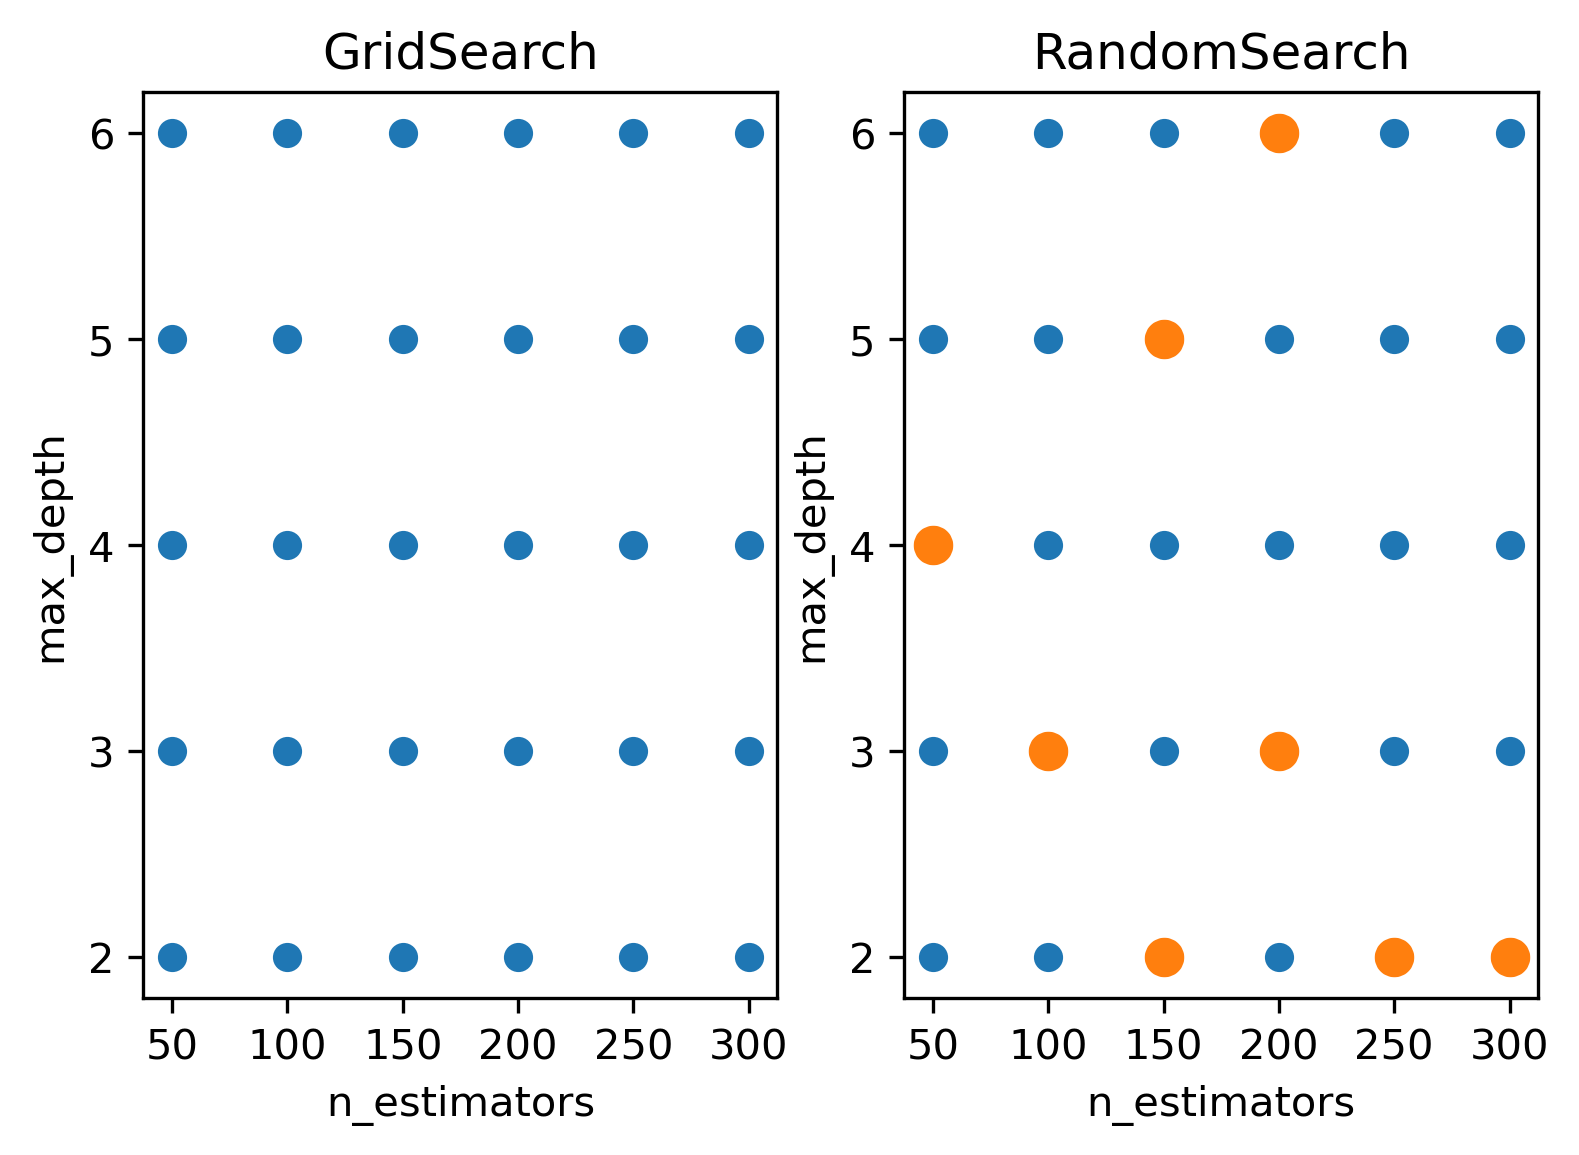

In [26]:
fig, [ax1, ax2] = plt.subplots(1,2,dpi=300)
n_e_list = [*range(50,350,50)]
m_d_list = [*range(2,7)]
comb = pd.DataFrame([(n_estimators, max_depth) for n_estimators in n_e_list for max_depth in m_d_list])

ax1.scatter(comb.iloc[:,0],comb.iloc[:,1],cmap="Blues")
ax1.set_xticks([*range(50,350,50)])
ax1.set_yticks([*range(2,7)])
ax1.set_xlabel("n_estimators")
ax1.set_ylabel("max_depth")
ax1.set_title("GridSearch")

ax2.scatter(comb.iloc[:,0],comb.iloc[:,1],cmap="Blues")
ax2.scatter([50,250,200,200,300,100,150,150],[4,2,6,3,2,3,2,5],cmap="red",s=20,linewidths=5)
ax2.set_xticks([*range(50,350,50)])
ax2.set_yticks([*range(2,7)])
ax2.set_xlabel("n_estimators")
ax2.set_ylabel("max_depth")
ax2.set_title("RandomSearch");

在sklearn中，随机抽取参数子空间并在子空间中进行搜索的方法叫做随机网格搜索RandomizedSearchCV。由于搜索空间的缩小，需要枚举和对比的参数组的数量也对应减少，整体搜索耗时也将随之减少，因此：

> 当设置相同的全域空间时，随机搜索的**运算速度**比枚举网格搜索**快**很多。<br>

> 当设置相同的训练次数时，随机搜索可以**覆盖的空间**比枚举网格搜索**大**很多。<br>

> 同时，绝妙的是，随机网格搜索得出的**最小损失**与枚举网格搜索得出的最小损失**很接近**。

可以说，是提升了运算速度，又没有过多地伤害搜索的精度。

不过，需要注意的是，**随机网格搜索在实际运行时，并不是先抽样出子空间，再对子空间进行搜索**，而是仿佛“循环迭代”一般，在这一次迭代中随机抽取1组参数进行建模，下一次迭代再随机抽取1组参数进行建模，由于这种随机抽样是不放回的，因此不会出现两次抽中同一组参数的问题。我们可以控制随机网格搜索的迭代次数，来控制整体被抽出的参数子空间的大小，这种做法往往被称为“赋予随机网格搜索固定的计算量，当全部计算量被消耗完毕之后，随机网格搜索就停止”。

- 随机网格搜索的实现

In [9]:
from sklearn.model_selection import RandomizedSearchCV

*class* `sklearn.model_selection.RandomizedSearchCV`(estimator, param_distributions, \*, n_iter=10, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', random_state=None, error_score=nan, return_train_score=False)

全部参数解读如下，其中加粗的是随机网格搜索独有的参数：

|Name|Description|      
|:--:|:--:|      
|estimator|调参对象，某评估器|      
|param_distributions|全域参数空间，可以是字典或者字典构成的列表|
|**n_iter**|迭代次数，迭代次数越多，抽取的子参数空间越大|
|scoring|评估指标，支持同时输出多个参数|
|n_jobs|设置工作时参与计算的线程数|
|refit|挑选评估指标和最佳参数，在完整数据集上进行训练|
|cv|交叉验证的折数|
|verbose|输出工作日志形式|
|pre_dispatch|多任务并行时任务划分数量|
|**random_state**|随机数种子|
|error_score|当网格搜索报错时返回结果，选择'raise'时将直接报错并中断训练过程，其他情况会显示警告信息后继续完成训练|
|return_train_score|在交叉验证中是否显示训练集中参数得分|

我们依然借用之前在网格搜索上见过的X和y，以及随机森林回归器，来实现随机网格搜索：

In [11]:
X.shape

(1460, 80)

In [12]:
X.head()

,Id,住宅类型,住宅区域,街道接触面积(英尺),住宅面积,街道路面状况,巷子路面状况,住宅形状(大概),住宅现状,水电气,...,半开放式门廊面积,泳池面积,泳池质量,篱笆质量,其他配置,其他配置的价值,销售月份,销售年份,销售类型,销售状态
0,0.0,5.0,3.0,36.0,327.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,4.0
1,1.0,0.0,3.0,51.0,498.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,8.0,4.0
2,2.0,5.0,3.0,39.0,702.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,8.0,4.0
3,3.0,6.0,3.0,31.0,489.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0
4,4.0,5.0,3.0,55.0,925.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,2.0,8.0,4.0


In [13]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

- 相同的全域参数空间

In [57]:
#创造参数空间 - 使用与网格搜索时完全一致的空间，以便于对比
param_grid_simple = {"criterion": ["squared_error","poisson"]
                     , 'n_estimators': [*range(20,100,5)]
                     , 'max_depth': [*range(10,25,2)]
                     , "max_features": ["log2","sqrt",16,32,64,"auto"]
                     , "min_impurity_decrease": [*np.arange(0,5,10)]
                    }

#建立回归器、交叉验证
reg = RFR(random_state=1412,verbose=True,n_jobs=-1)
cv = KFold(n_splits=5,shuffle=True,random_state=1412)

In [58]:
#计算全域参数空间大小，这是我们能够抽样的最大值
count_space(param_grid_simple)

1536


In [59]:
#定义随机搜索
search = RandomizedSearchCV(estimator=reg
                            ,param_distributions=param_grid_simple
                            ,n_iter = 800 #子空间的大小是全域空间的一半左右
                            ,scoring = "neg_mean_squared_error"
                            ,verbose = True
                            ,cv = cv
                            ,random_state=1412
                            ,n_jobs=-1
                           )

In [17]:
#训练随机搜索评估器
#=====【TIME WARNING: 5~10min】=====#
start = time.time()
search.fit(X,y)
print(time.time() - start)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
170.16785073280334


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    0.0s finished


In [21]:
170.1678/60

2.83613

In [19]:
#查看模型结果
search.best_estimator_

RandomForestRegressor(max_depth=24, max_features=16, min_impurity_decrease=0,
                      n_estimators=85, n_jobs=-1, random_state=1412,
                      verbose=True)

In [20]:
abs(search.best_score_)**0.5

29251.284326350575

In [23]:
#根据最优参数重建模型
ad_reg = RFR(max_depth=24, max_features=16, min_impurity_decrease=0,
                      n_estimators=85, n_jobs=-1, random_state=1412,
                      verbose=True)
rebuild_on_best_param(ad_reg)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


训练RMSE:11031.299
测试RMSE:28639.969


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


|HPO方法|默认参数|网格搜索|随机搜索|
|:-:|:-:|:-:|:-:|
|搜索空间/全域空间|-|1536/1536|800/1536|
|运行时间（分钟）|-|6.36|<font color="green">**2.83(↓)**</font>|
|搜索最优（RMSE）|30571.266|29179.698|29251.284|
|重建最优（RMSE）|-|28572.070|<font color="brown">**28639.969(↑)**</font>|

很明显，在相同参数空间、相同模型的情况下，随机网格搜索的运算速度是普通网格搜索的一半，当然，这与子空间是全域空间的一半有很大的联系。由于随机搜索只是降低搜索的次数，并非影响搜索过程本身，因此其运行时间基本就等于n_iter/全域空间组合数 * 网格搜索的运行时间。

- 随机网格搜索的理论极限

虽然通过缩小子空间可以提升搜索的速度，但是随机网格搜索的精度看起来并没有削减太多，随机网格搜索可以得到和网格搜索一样好的结果吗？它也像网格搜索一样，可以得到最优的参数组合吗？为什么缩小参数空间之后，随机网格搜索的结果还与网格搜索一致？

**理论上来说，枚举网格搜索的上限和随机网格搜索的上限哪个高？**

从直觉上来说，我们很难回答这些问题，但我们可以从数学的随机过程的角度来理解这个问题。在机器学习算法当中，有非常多通过随机来提升运算速度（比如Kmeans，随机挑选样本构建簇心，小批量随机梯度下降，通过随机来减少每次迭代需要的样本）、或通过随机来提升模型效果的操作（比如随机森林，比如极度随机树）。两种随机背后的原理完全不同，而随机网格搜索属于前者，这一类机器学习方法总是伴随着“从某个全数据集/全域中进行抽样”的操作，而这种操作能够有效的根本原因在于：

> - 抽样出的子空间可以一定程度上反馈出全域空间的分布，且子空间相对越大（含有的参数组合数越多），子空间的分布越接近全域空间的分布<br><br>
> - 当全域空间本身足够密集时，很小的子空间也能获得与全域空间相似的分布<br><br>
> - 如果全域空间包括了理论上的损失函数最小值，那一个与全域空间分布高度相似的子空间很可能也包括损失函数的最小值，或包括非常接近最小值的一系列次小值<br>

上述数学事实听起来比较抽象，但其实我们可以通过绘制图像来直观地呈现这些事实。许多在数学上比较抽象的概念都可以被可视化。在这里，我们借助matplotlib工具库mplot3d中的一组默认数据。

In [61]:
from mpl_toolkits.mplot3d import axes3d

In [84]:
p1, p2, MSE = axes3d.get_test_data(0.05)
#自动获取数据的功能get_test_data，可以自动生成复合某一分布的数据
#我们现在假设这一组数据中有两个参数，p1与p2，两个参数组成的参数组合对应着损失函数值MSE
#参数0.05是指参数空间中，点与点之间的距离
#因此该数字越小，取出来的样本越多

In [85]:
len(p1) #参数1的取值有120个

120

In [86]:
len(p2) #参数2的取值也有120个

120

请问现在参数空间当中一共有多少个参数组合？120*120=14400种组合，所以参数空间中一共有14400个点。

In [87]:
MSE.shape #损失函数值，总共14400个点

(120, 120)

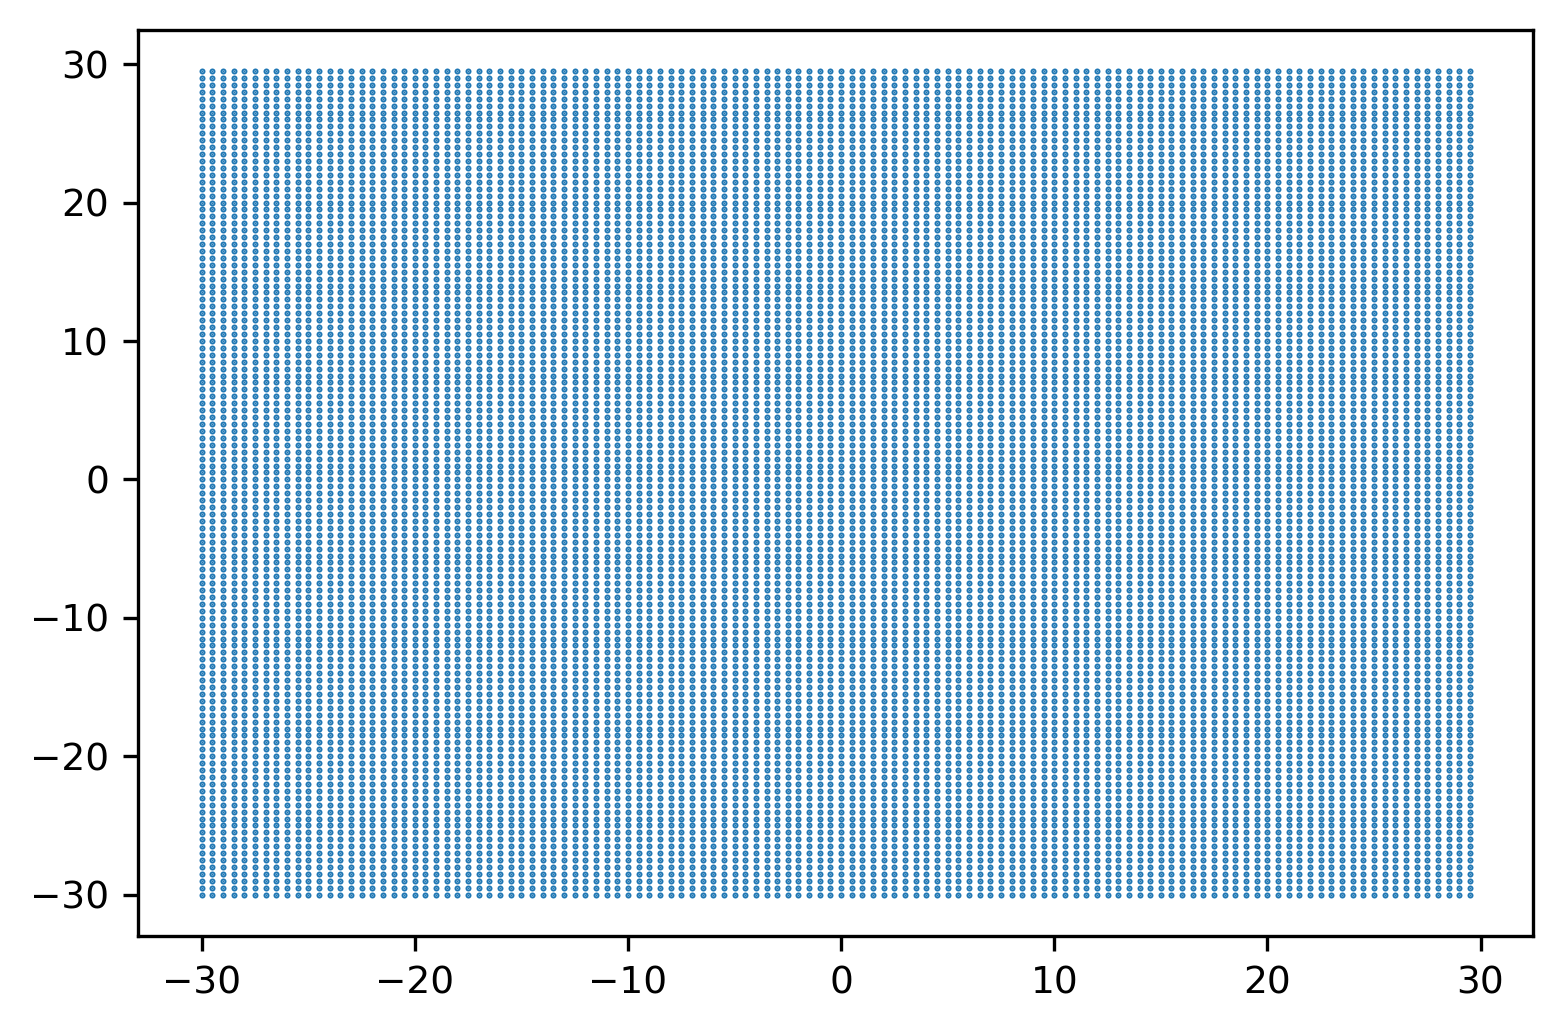

In [66]:
#绘制P1与P2的参数空间 - 这是一个呈现出14400个点的密集空间
plt.figure(dpi=300)
plt.scatter(p1,p2,s=0.2)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9);

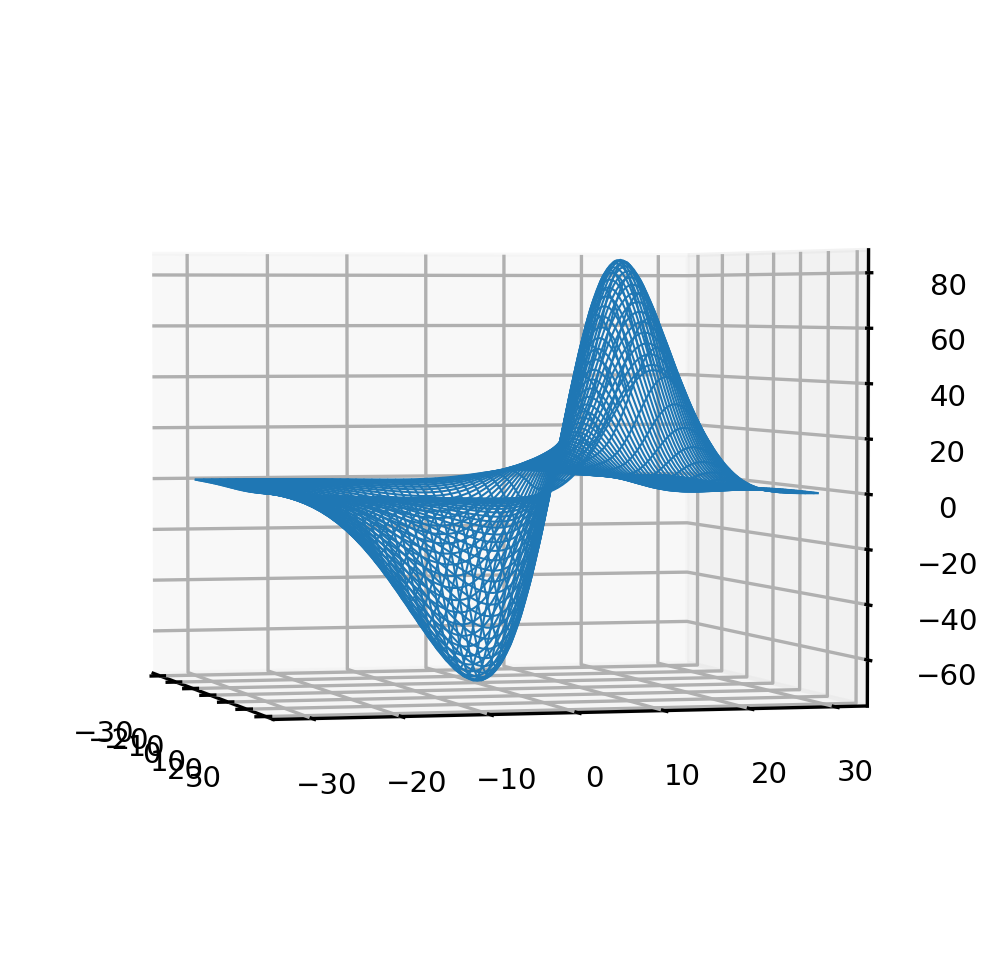

In [95]:
#参数与损失共同构建的函数
p1, p2, MSE = axes3d.get_test_data(0.05)
plt.figure(dpi=300)
ax = plt.axes(projection="3d")
ax.plot_wireframe(p1,p2,MSE,rstride=2,cstride=2,linewidth=0.5)
ax.view_init(2, -15)
ax.zaxis.set_tick_params(labelsize=7)
ax.xaxis.set_tick_params(labelsize=7)
ax.yaxis.set_tick_params(labelsize=7);

In [284]:
np.min(MSE) #整个参数空间中，可获得的MSE最小值是-73.39

-73.39620971601681

In [11]:
#现在，我们从该空间上抽取子空间
import numpy as np

In [93]:
MSE.shape

(120, 120)

In [105]:
#我们从空间中抽取n个组合，n越大子空间越大
#现在总共有14400个组合
#对被抽中的点来说，损失函数的值就是MSE，对没有抽中的点来说，损失函数值是空值
#因此，我们只需要找出没有抽中的点，并让它的损失函数值MSE为空就可以了

n = 100

-73.24243733589367


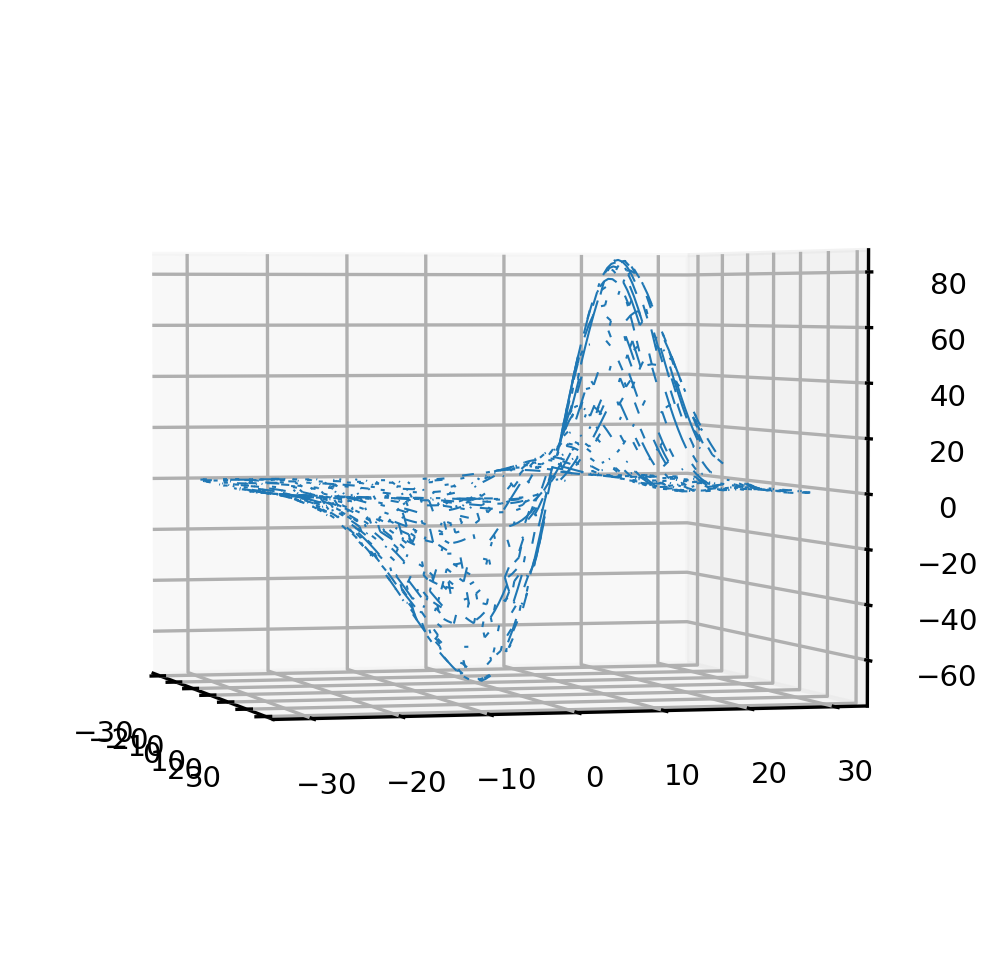

In [106]:
#从0~14400中生成(14400-n)个随机数，形成没有被抽到子空间中的点的索引
unsampled = np.random.randint(0,14400,14400-n)

p1, p2, MSE = axes3d.get_test_data(0.05)

#拉平MSE，并将所有没抽中的点的损失函数变为空值
MSE = MSE.ravel()
MSE[unsampled] = np.nan
MSE = MSE.reshape((120,120))
#设置完毕空值后，记得把MSE恢复成原来的结构，否则绘图报错

#参数与损失共同构建的函数
plt.figure(dpi=300)
ax = plt.axes(projection="3d")
ax.view_init(2, -15)
ax.plot_wireframe(p1,p2,MSE,rstride=2,cstride=2,linewidth=0.5)
ax.zaxis.set_tick_params(labelsize=7)
ax.xaxis.set_tick_params(labelsize=7)
ax.yaxis.set_tick_params(labelsize=7);

#求出当前损失函数上的最小值
#注意此时因为MSE中含有了空值，因此要先排除空值影响，否则min函数会返回空值
MSE = MSE.ravel().tolist()
MSE = [x for x in MSE if str(x) != 'nan']
print(np.min(MSE))

我们可以在图像上验证如下事实：

> - 抽样出的子空间可以一定程度上反馈出全域空间的分布，且子空间相对越大（含有的参数组合数越多），子空间的分布越接近全域空间的分布<br><br>
> - 当全域空间本身足够密集时，很小的子空间也能获得与全域空间相似的分布<br><br>
> - 如果全域空间包括了理论上的损失函数最小值，那一个与全域空间分布高度相似的子空间很可能也包括损失函数的最小值，或包括非常接近最小值的一系列次小值<br>

因此，只要子空间足够大，随机网格搜索的效果一定是高度逼近枚举网格搜索的。**在全域参数空间固定时，随机网格搜索可以在效率与精度之间做权衡**。子空间越大，精度越高，子空间越小，效率越高。

- 更大/更密集的全域空间

不过，由于随机网格搜索计算更快，所以在相同计算资源的前提下，我们可以对随机网格搜索使用更大的全域空间，因此随机搜索可能得到比网格搜索更好的效果：

In [109]:
#创造参数空间 - 让整体参数空间变得更密
param_grid_simple = {'n_estimators': [*range(80,100,1)]
                     , 'max_depth': [*range(10,25,1)]
                     , "max_features": [*range(10,20,1)]
                     , "min_impurity_decrease": [*np.arange(0,5,10)]
                    }

In [110]:
#计算全域参数空间大小，这是我们能够抽样的最大值
count_space(param_grid_simple)

3000


In [105]:
#建立回归器、交叉验证
reg = RFR(random_state=1412,verbose=True,n_jobs=-1)
cv = KFold(n_splits=5,shuffle=True,random_state=1412)

#定义随机搜索
search = RandomizedSearchCV(estimator=reg
                            ,param_distributions=param_grid_simple
                            ,n_iter = 1536 #使用与枚举网格搜索类似的拟合次数
                            ,scoring = "neg_mean_squared_error"
                            ,verbose = True
                            ,cv = cv
                            ,random_state=1412
                            ,n_jobs=-1)

In [106]:
#训练随机搜索评估器
#=====【TIME WARNING: 5~10min】=====#
start = time.time()
search.fit(X,y)
end = time.time() - start
print(end/60)

Fitting 5 folds for each of 1536 candidates, totalling 7680 fits
3.8464645385742187


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    0.0s finished


In [107]:
#查看最佳评估器
search.best_estimator_

RandomForestRegressor(max_depth=22, max_features=14, min_impurity_decrease=0,
                      n_estimators=89, n_jobs=-1, random_state=1412,
                      verbose=True)

In [108]:
#查看最终评估指标
abs(search.best_score_)**0.5

29012.90569846546

In [109]:
rebuild_on_best_param(search.best_estimator_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


训练RMSE:11208.818
测试RMSE:28346.673


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


|HPO方法|默认参数|网格搜索|随机搜索|随机搜索<br>(大空间)|
|:-:|:-:|:-:|:-:|:-:|
|搜索空间/全域空间|-|1536/1536|800/1536|1536/3000|
|运行时间（分钟）|-|6.36|<font color="green">**2.83(↓)**</font>|<font color="green">**3.86(↓)**</font>|
|搜索最优（RMSE）|30571.266|29179.698|29251.284|<font color="green">**29012.905(↓)**</font>|
|重建最优（RMSE）|-|28572.070|<font color="brown">**28639.969(↑)**</font>|<font color="green">**28346.673(↓)**</font>|

可以发现，当全域参数空间增大之后，随即网格搜索可以使用与小空间上的网格搜索相似或更少的时间，来探索更密集/更大的空间，从而获得更好的结果。除了可以容忍更大的参数空间之外，随机网格搜索还可以接受连续性变量作为参数空间的输入。

- 连续型的参数空间

![](https://miro.medium.com/max/1400/0*yDmmJmvRowl0cSN8.png)

对于网格搜索来说，参数空间中的点是分布均匀、间隔一致的，因为网格搜索无法从某种“分布”中提取数据，只能使用组合好的参数组合点，而随机搜索却可以接受“分布”作为输入。如上图所示，对于网格搜索来说，损失函数的最低点很不幸的、位于两组参数之间，在这种情况下，枚举网格搜索是100%不可能找到最小值的。但对于随机网格搜索来说，由于是一段分布上随机选择参数点，因此在同样的参数空间中，取到更好的值的可能性更大。

In [112]:
import scipy #使用scipy来帮助我们建立分布

In [113]:
scipy.stats.uniform(loc=1,scale=100)

uniform是均匀分布，默认生成[0,1]之间的数字，可以使用loc来调整起点，scale来调整终点。我们还可以选择其他的分布，比如指数分布expon, gamma分布, 或者是randint。注意scipy这里并不是像np.linspace()一样生成一段离散的数字，而是直接生成一个分布对象。并且，**我们并没有在分布对象中指定尺寸，也就是说，在这段分布上究竟要取几个随机的参数备选值，是由随机搜索自己决定的**。理论上来说，我们给出的n_iter越大，任意参数的分布上可能被取到的点就越多。因此，当参数空间中包含某个分布的时候，我们无法估计全域参数空间的大小。

在之前调整随机森林的时候，我们给出的所有参数都是只能接纳正整数的参数，因此在这里我们可以使用scipy.stats.randint，不过randint并不是严格意义上的连续分布。

严格来说，连续型搜索更适用于学习率，C，alpha这样的参数（无上限，以浮点数为主），随机森林的参数中最接近这个定义的是min_impurity_decrease，表示决策树在分枝是可以容忍的最小的不纯度下降量。我们借着这个参数，使用均匀分布来进行搜索试试看。

In [121]:
param_grid_simple = {'n_estimators': [*range(80,100,1)]
                     , 'max_depth': [*range(10,25,1)]
                     , "max_features": [*range(10,20,1)]
                     , "min_impurity_decrease": scipy.stats.uniform(0,50)
                    }

In [122]:
#建立回归器、交叉验证
reg = RFR(random_state=1412,verbose=True,n_jobs=12)
cv = KFold(n_splits=5,shuffle=True,random_state=1412)

#定义随机搜索
search = RandomizedSearchCV(estimator=reg
                            ,param_distributions=param_grid_simple
                            ,n_iter = 1536 #还是使用1536这个搜索次数
                            ,scoring = "neg_mean_squared_error"
                            ,verbose = True
                            ,cv = cv
                            ,random_state=1412
                            ,n_jobs=12)

In [123]:
#训练随机搜索评估器
#=====【TIME WARNING: 5~10min】=====#
start = time.time()
search.fit(X,y)
end = time.time() - start
print(end/60)

Fitting 5 folds for each of 1536 candidates, totalling 7680 fits
3.921058924992879


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  98 out of  98 | elapsed:    0.0s finished


In [124]:
#查看最佳评估器
search.best_estimator_

RandomForestRegressor(max_depth=22, max_features=14,
                      min_impurity_decrease=20.070367229896224, n_estimators=98,
                      n_jobs=12, random_state=1412, verbose=True)

In [127]:
#查看最终评估指标
abs(search.best_score_)**0.5

29148.381610182565

In [128]:
rebuild_on_best_param(search.best_estimator_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


训练RMSE:11184.428
测试RMSE:28495.682


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


|HPO方法|默认参数|网格搜索|随机搜索|随机搜索<br>(大空间)|随机搜索<br>(连续型)|
|:-:|:-:|:-:|:-:|:-:|:-:|
|搜索空间/全域空间|-|1536/1536|800/1536|1536/3000|1536/无限|
|运行时间（分钟）|-|6.36|<font color="green">**2.83(↓)**</font>|<font color="green">**3.86(↓)**</font>|3.92|
|搜索最优（RMSE）|30571.266|29179.698|29251.284|<font color="green">**29012.905(↓)**</font>|29148.381|
|重建最优（RMSE）|-|28572.070|<font color="brown">**28639.969(↑)**</font>|<font color="green">**28346.673(↓)**</font>|28495.682|

在本次搜索当中，由于我们之前已经知道最好的可能的min_impurity_decrease的值为0，因此强行向更大的数拓展搜索空间可能会导致模型效果下降。不过在随机森林当中，min_impurity_decrease是唯一可以使用分布进行搜索的参数，因此在这里我们就容忍了这部分表现上升。

理论上来说，当枚举网格搜索所使用的全域参数空间足够大/足够密集时，枚举网格搜索的最优解是随机网格搜索的上限，因此**理论上随机网格搜索不会得到比枚举网格搜索更好的结果**。

但现实中的问题是，由于枚举网格搜索的速度太慢，因此枚举网格搜索的全域参数空间往往无法设置得很大，也无法设置得很密集，因此网格搜索的结果很难接近理论上的最优值。当随机网格搜索将空间设置更大、更密集时，就可以捕获更广空间的分布，也自然就可能捕获到理论上的最优值了。

# 三 对半网格搜索HalvingSearchCV

- 基本原理

在讲解随机网格搜索之前，我们梳理了决定枚举网格搜索运算速度的因子：

> 1 参数空间的大小：参数空间越大，需要建模的次数越多<br>
> 2 数据量的大小：数据量越大，每次建模时需要的算力和时间越多<br>

面对枚举网格搜索过慢的问题，sklearn中呈现了两种优化方式：其一是**调整搜索空间**，其二是调整**每次训练的数据**。调整搜索空间的方法就是随机网格搜索，而调整每次训练数据的方法就是对半网格搜索。

假设现在存在数据集$D$，我们从数据集$D$中随机抽样出一个子集$d$。如果一组参数在整个数据集$D$上表现较差，那大概率这组参数在数据集的子集$d$上表现也不会太好。反之，如果一组参数在子集$d$上表现不好，我们也不会信任这组参数在全数据集$D$上的表现。**参数在子集与全数据集上反馈出的表现一致**，如果这一假设成立，那在网格搜索中，比起每次都使用全部数据来验证一组参数，或许我们可以考虑只带入训练数据的子集来对超参数进行筛选，这样可以极大程度地加速我们的运算。

但在现实数据中，这一假设要成立是有条件的，即**任意子集的分布都与全数据集D的分布类似**。当子集的分布越接近全数据集的分布，同一组参数在子集与全数据集上的表现越有可能一致。根据之前在随机网格搜索中得出的结论，我们知道子集越大、其分布越接近全数据集的分布，但是大子集又会导致更长的训练时间，因此为了整体训练效率，我们不可能无限地增大子集。这就出现了一个矛盾：大子集上的结果更可靠，但大子集计算更缓慢。对半网格搜索算法设计了一个精妙的流程，可以很好的权衡子集的大小与计算效率问题，我们来看具体的流程：

> 1、首先从全数据集中无放回随机抽样出一个很小的子集$d_0$，并在$d_0$上验证全部参数组合的性能。根据$d_0$上的验证结果，淘汰评分排在后1/2的那一半参数组合<br><br>
> 2、然后，从全数据集中再无放回抽样出一个比$d_0$大一倍的子集$d_1$，并在$d_1$上验证剩下的那一半参数组合的性能。根据$d_1$上的验证结果，淘汰评分排在后1/2的参数组合<br><br>
> 3、再从全数据集中无放回抽样出一个比$d_1$大一倍的子集$d_2$，并在$d_2$上验证剩下1/4的参数组合的性能。根据$d_2$上的验证结果，淘汰评分排在后1/2的参数组合……

持续循环。如果使用S代表首次迭代时子集的样本量，C代表全部参数组合数，则在迭代过程中，用于验证参数的数据子集是越来越大的，而需要被验证的参数组合数量是越来越少的：

|迭代次数|子集样本量|参数组合数|
|:-:|:-:|:-:|
|1|S|C|
|2|2S|$\frac{1}{2}$C|
|3|4S|$\frac{1}{4}$C|
|4|8S|$\frac{1}{8}$C|
……

<center>（当C无法被除尽时，则向上取整）</center><br>

当**备选参数组合只剩下一组，或剩余可用的数据不足**，循环就会停下，具体地来说，**当$\frac{1}{n}$C <= 1或者nS > 总体样本量，搜索就会停止**。在实际应用时，哪一种停止条件会先被触发，需要看实际样本量及参数空间地大小。同时，每次迭代时增加的样本量、以及每次迭代时不断减少的参数组合都是可以自由设定的。

在这种模式下，只有在不同的子集上不断获得优秀结果的参数组合能够被留存到迭代的后期，最终选择出的参数组合一定是在所有子集上都表现优秀的参数组合。这样一个参数组合在全数据上表现优异的可能性是非常大的，同时也可能展现出比网格/随机搜索得出的参数更大的泛化能力。

- 对半网格搜索的局限性

然而这个过程当中会存在一个问题：子集越大时，子集与全数据集D的分布会越相似，但整个对半搜索算法在开头的时候，就用最小的子集筛掉了最多的参数组合。如果最初的子集与全数据集的分布差异巨大的化，在对半搜索开头的前几次迭代中，就可能筛掉许多对全数据集D有效的参数，因此对半网格搜索最初的子集一定不能太小。

在对半网格搜索过程中，子集的样本量时呈指数级增长：

In [117]:
n = 10
for i in range(15):
    print(i,n*3**i)

0 10
1 30
2 90
3 270
4 810
5 2430
6 7290
7 21870
8 65610
9 196830
10 590490
11 1771470
12 5314410
13 15943230
14 47829690


在初始子集样本量为10的前提下，7、8次迭代就会消耗掉2500+数据资源。在初始子集一定不能太小、且对半搜索的抽样是不放回抽样的大前提下，**整体数据的样本量必须要很大**。从经验来看，对半网格搜索在小型数据集上的表现往往不如随机网格搜索与普通网格搜索，事实上，如果我们在Kaggle房价数据集上使用对半网格搜索，会发现其搜索结果还不如枚举网格搜索、且搜索时间长于之前我们尝试过的任何一种搜索方式。但在大型数据集上（比如，样本量过w的数据集上），对半网格搜索则展现出运算速度和精度上的巨大优势。

因此在对半网格搜索实现时，我们使用一组拓展的房价数据集，有2w9条样本。

In [113]:
data2 = pd.read_csv(r"D:\Pythonwork\2021ML\PART 2 Ensembles\datasets\House Price\big_train.csv",index_col=0)

In [114]:
X = data2.iloc[:,:-1]
y = data2.iloc[:,-1]

In [115]:
X.shape

(29062, 80)

In [116]:
y.describe()

count     29062.000000
mean     182798.864703
std       72379.404452
min       34900.000000
25%      139000.000000
50%      169092.000000
75%      203009.750000
max      755000.000000
Name: SalePrice, dtype: float64

In [8]:
X.head()

,Id,住宅类型,住宅区域,街道接触面积(英尺),住宅面积,街道路面状况,巷子路面状况,住宅形状(大概),住宅现状,水电气,...,半开放式门廊面积,泳池面积,泳池质量,篱笆质量,其他配置,其他配置的价值,销售月份,销售年份,销售类型,销售状态
0,0.0,5.0,3.0,36.0,327.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,4.0
1,1.0,0.0,3.0,51.0,498.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,8.0,4.0
2,2.0,5.0,3.0,39.0,702.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,8.0,4.0
3,3.0,6.0,3.0,31.0,489.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0
4,4.0,5.0,3.0,55.0,925.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,2.0,8.0,4.0


- 对半网格搜索的实现

在sklearn当中，我们可以使用HalvingGridSearchCV类来实现对半网格搜索。Halving搜索是sklearn 1.0.1版本才新增的功能，因此现在该功能还处于实验阶段，在导入该类的时候需要同时导入用以开启对半网格搜索的辅助功能enable_halving_search_cv。当且仅当该功能被导入时，HalvingGridSearchCV才能够被导入和使用。

In [34]:
import re
import sklearn
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import time
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import KFold, HalvingGridSearchCV, cross_validate, RandomizedSearchCV

对半网格搜索的类如下所示：

*class* `sklearn.model_selection.HalvingGridSearchCV`(estimator, param_grid, *, factor=3, resource='n_samples', max_resources='auto', min_resources='exhaust', aggressive_elimination=False, cv=5, scoring=None, refit=True, error_score=nan, return_train_score=True, random_state=None, n_jobs=None, verbose=0)

全部参数如下所示：

|Name|Description|      
|:--:|:--:|      
|estimator|调参对象，某评估器|      
|param_grid|参数空间，可以是字典或者字典构成的列表|
|**factor**|每轮迭代中新增的样本量的比例，同时也是每轮迭代后留下的参数组合的比例|
|**resource**|设置每轮迭代中增加的验证资源的类型|
|**max_resources**|在一次迭代中，允许被用来验证任意参数组合的最大样本量|
|**min_resources**|首次迭代时，用于验证参数组合的样本量r0|
|**aggressive_elimination**|是否以全部数被使用完成作为停止搜索的指标，如果不是，则采取措施|
|cv|交叉验证的折数|
|scoring|评估指标，支持同时输出多个参数|
|refit|挑选评估指标和最佳参数，在完整数据集上进行训练|
|error_score|当网格搜索报错时返回结果，选择'raise'时将直接报错并中断训练过程<br>其他情况会显示警告信息后继续完成训练|
|return_train_score|在交叉验证中是否显示训练集中参数得分|
|**random_state**|控制随机抽样数据集的随机性|
|n_jobs|设置工作时参与计算的线程数|
|verbose|输出工作日志形式|

- **factor**

每轮迭代中新增的样本量的比例，同时也是每轮迭代后留下的参数组合的比例。例如，当factor=2时，下一轮迭代的样本量会是上一轮的2倍，每次迭代后有1/2的参数组合被留下。如果factor=3时，下一轮迭代的样本量会是上一轮的3倍，每次迭代后有1/3的参数组合被留下。该参数通常取3时效果比较好。

- **resource**

设置每轮迭代中增加的验证资源的类型，输入为字符串。默认是样本量，输入为"n_samples"，也可以是任意集成算法当中输入正整数的弱分类器，例如"n_estimators"或者"n_iteration"。

- **min_resource**

首次迭代时，用于验证参数组合的样本量r0。可以输入正整数，或两种字符串"smallest","exhaust"。<br>
输入正整数n，表示首次迭代时使用n个样本。<br>
输入"smallest"，则根据规则计算r0:<br>
> 当资源类型是样本量时，对回归类算法，r0 = 交叉验证折数n_splits * 2<br>
> 当资源类型是样本量时，对分类算法，r0 = 类别数量n_classes_ * 交叉验证折数n_splits * 2<br>
> 当资源类型不是样本量时，等于1<br>

输入"exhaust"，则根据迭代最后一轮的最大可用资源倒退r0。例如，factor=2, 样本量为1000时，一共迭代3次时，则最后一轮迭代的最大可用资源为1000，倒数第二轮为500，倒数第三轮（第一轮）为250。此时r0 = 250。"exhaust"模式下最有可能得到好的结果，不过计算量会略大，计算时间会略长。

现在，我们依然使用网格搜索最初的，空间大小为1536的参数空间：

In [31]:
param_grid_simple = {"criterion": ["squared_error","poisson"]
                     , 'n_estimators': [*range(20,100,5)]
                     , 'max_depth': [*range(10,25,2)]
                     , "max_features": ["log2","sqrt",16,32,64,"auto"]
                     , "min_impurity_decrease": [*np.arange(0,5,10)]
                    }

In [13]:
count_space(param_grid_simple)

1536


In [118]:
X.shape

(29062, 80)

哪一种停止条件会被触发？

In [119]:
#2.9w个样本在factor=2, min_resource = 100的情况下可以迭代多久？
for i in range(100):
    if 100*2**i > 29062:
        break
    print(i+1,100*2**i)

1 100
2 200
3 400
4 800
5 1600
6 3200
7 6400
8 12800
9 25600


In [120]:
#1536种参数组合在factor=2的情况下可以迭代多久？
for i in range(100):
    if 1536//2**i < 1:
        break
    print(i+1,int(1536//2**i+1)) #向上取整

1 1537
2 769
3 385
4 193
5 97
6 49
7 25
8 13
9 7
10 4
11 2


不难发现，当factor=2的时候，数据集不足的条件会先被触发，最多只能迭代9次。也就是说，最终我们将在7组参数中选择表现最好的一组参数，而不会一直让搜索持续直到找出唯一最优的参数。如果我们无论如何都希望能够找到唯一最后的参数，那我们可以使用下面的参数：

- **aggressive_elimination**

输入布尔值，默认False。当数据总样本量较小，不足以支撑循环直到只剩下最后一组备选参数时，可以打开该参数。
> 参数设置为True时，会重复使用首次迭代时的样本量，直到剩下的数据足以支撑样本量的增加直到只剩下最后一组备选参数<br>
> 参数设置为False时，以全部样本被用完作为搜索结束的指标<br>

对于对半网格搜索应用来说，最困难的部分就是决定搜索本身复杂的参数组合。在调参时，如果我们希望参数空间中的备选组合都能够被充分验证，则迭代次数不能太少（例如，只迭代3次），因此factor不能太大。但如果factor太小，又会加大迭代次数，同时拉长整个搜索的运行时间。同时，迭代次数还会影响我们最终能够使用的数据量，以及迭代完毕之后我们还需进一步验证的参数组合数量，两者都不能太少。因此，我们一般在使用对半网格搜索时，需考虑以下三个点：

1、min_resources的值不能太小，且在全部迭代过程结束之前，我们希望使用尽量多的数据<br>
2、迭代完毕之后，剩余的验证参数组合不能太多，10以下最佳，如果无法实现，则30以下也可以接受<br>
3、迭代次数不能太多，否则时间可能会太长

In [140]:
factor = 1.5
n_samples = X.shape[0]
min_resources = 500
space = 1536

In [141]:
for i in range(100):
    if (min_resources*factor**i > n_samples) or (space/factor**i < 1):
        break
    print(i+1,"本轮迭代样本:{}".format(min_resources*factor**i)
          ,"本轮验证参数组合:{}".format(space//factor**i + 1))

1 本轮迭代样本:500.0 本轮验证参数组合:1537.0
2 本轮迭代样本:750.0 本轮验证参数组合:1025.0
3 本轮迭代样本:1125.0 本轮验证参数组合:683.0
4 本轮迭代样本:1687.5 本轮验证参数组合:456.0
5 本轮迭代样本:2531.25 本轮验证参数组合:304.0
6 本轮迭代样本:3796.875 本轮验证参数组合:203.0
7 本轮迭代样本:5695.3125 本轮验证参数组合:135.0
8 本轮迭代样本:8542.96875 本轮验证参数组合:90.0
9 本轮迭代样本:12814.453125 本轮验证参数组合:60.0
10 本轮迭代样本:19221.6796875 本轮验证参数组合:40.0
11 本轮迭代样本:28832.51953125 本轮验证参数组合:27.0


In [22]:
#建立回归器、交叉验证
reg = RFR(random_state=1412,verbose=True,n_jobs=-1)
cv = KFold(n_splits=5,shuffle=True,random_state=1412)

#定义对半搜索
search = HalvingGridSearchCV(estimator=reg
                            ,param_grid=param_grid_simple
                            ,factor=1.5
                            ,min_resources=500
                            ,scoring = "neg_mean_squared_error"
                            ,verbose = True
                            ,random_state=1412
                            ,cv = cv
                            ,n_jobs=-1)

In [23]:
#训练对半搜索评估器
#=====【TIME WARNING: 30~50min】=====#
start = time.time()
search.fit(X,y)
end = time.time() - start
print(end/60)

n_iterations: 11
n_required_iterations: 19
n_possible_iterations: 11
min_resources_: 500
max_resources_: 29062
aggressive_elimination: False
factor: 1.5
----------
iter: 0
n_candidates: 1536
n_resources: 500
Fitting 5 folds for each of 1536 candidates, totalling 7680 fits
----------
iter: 1
n_candidates: 1024
n_resources: 750
Fitting 5 folds for each of 1024 candidates, totalling 5120 fits
----------
iter: 2
n_candidates: 683
n_resources: 1125
Fitting 5 folds for each of 683 candidates, totalling 3415 fits
----------
iter: 3
n_candidates: 456
n_resources: 1687
Fitting 5 folds for each of 456 candidates, totalling 2280 fits
----------
iter: 4
n_candidates: 304
n_resources: 2531
Fitting 5 folds for each of 304 candidates, totalling 1520 fits
----------
iter: 5
n_candidates: 203
n_resources: 3796
Fitting 5 folds for each of 203 candidates, totalling 1015 fits
----------
iter: 6
n_candidates: 136
n_resources: 5695
Fitting 5 folds for each of 136 candidates, totalling 680 fits
----------
it

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s


25.638246742884316


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.2s finished


In [28]:
#查看最佳评估器
search.best_estimator_

RandomForestRegressor(max_depth=22, max_features=16, min_impurity_decrease=0,
                      n_estimators=90, n_jobs=-1, random_state=1412,
                      verbose=True)

In [29]:
#查看最佳评估器
abs(search.best_score_)**0.5

1068.281607238587

In [30]:
#验证最佳参数组合的效力
rebuild_on_best_param(search.best_estimator_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


训练RMSE:475.740
测试RMSE:1082.916


以随机网格搜索作为对比，我们来看看随机网格搜索的结果：

In [35]:
param_grid_simple = {"criterion": ["squared_error","poisson"]
                     , 'n_estimators': [*range(20,100,5)]
                     , 'max_depth': [*range(10,25,2)]
                     , "max_features": ["log2","sqrt",16,32,64,"auto"]
                     , "min_impurity_decrease": [*np.arange(0,5,10)]
                    }

reg = RFR(random_state=1412,verbose=True,n_jobs=-1)
cv = KFold(n_splits=5,shuffle=True,random_state=1412)

In [36]:
#定义随机搜索
search = RandomizedSearchCV(estimator=reg
                            ,param_distributions=param_grid_simple
                            ,n_iter = 800 #使用全域空间的一半作为子空间
                            ,scoring = "neg_mean_squared_error"
                            ,verbose = True
                            ,random_state=1412
                            ,cv = cv
                            ,n_jobs=-1)

In [37]:
#训练随机搜索评估器
#=====【TIME WARNING: 1个半小时~2小时】=====#
start = time.time()
search.fit(X,y)
end = time.time()-start
print(end/60)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s


103.20144965251286


[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    1.2s finished


In [41]:
#查看最佳评估器
search.best_estimator_

RandomForestRegressor(max_depth=24, max_features=16, min_impurity_decrease=0,
                      n_estimators=85, n_jobs=-1, random_state=1412,
                      verbose=True)

In [42]:
#查看最终评估指标
abs(search.best_score_)**0.5

1055.5552571413887

In [43]:
#验证最佳参数组合的效力
rebuild_on_best_param(search.best_estimator_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


训练RMSE:465.198
测试RMSE:1054.359


|HPO方法|随机搜索|对半搜索|
|:-:|:-:|:-:|
|搜索空间/全域空间|800/1536|1536/1536|
|运行时间（分钟）|103.20|<font color="green">**25.638(↓)**</font>|
|搜索最优（RMSE）|1055.555|1068.281|
|重建最优（RMSE）|1054.359|1082.916|

可以看到，随机网格搜索的结果略微占优，但能够尝试的参数组合只有800个，且耗费的时间是对半搜索的4倍（1小时45分钟）。对于对半搜索，我们可以继续精细化调整整体的参数空间，进一步寻找更优的参数，但面对上万样本量的数据集，随机搜索的运算速度不足以支撑精细化调参，就更别提网格搜索了。之后，我们会给大家更详细地讲解更快速、更高效的优化方法。

# 四 【加餐】自动化机器学习AutoML

- 什么是AutoML？

在过去十年内，机器学习领域获得了巨大的进展，得益于互联网（数据）与芯片（算力）行业的快速发展，各类机器学习算法终于化理论为实践，被应用当各行各业、千家万户。如今，越来越多的科研领域依赖机器学习算法，机器学习算法的实现也因sklearn等算法库而变得轻便简单，但真正高水平的应用却很大程度依赖于机器学习算法工程师的经验。

**现代机器学习系统不止是关系到编程、数学等技能，更是伴随着众多基于经验和专业性的设计决策**，包括如何构筑特征、选择模型，如何设置超参数空间（parameter space）、如何设置神经网络结构、如何排布和管理数据处理管道（pipeline）等等。在实际的机器学习系统搭建过程当中，有超过80%的时间都在处理基于经验的设计决策，而决策所需的专业性拉开了算法工程专家与普通编程者的距离，也拉开了算法专业人员与业务人员的距离。

虽然机器学习领域的高专业性保障了算法工程师的稀缺性与高待遇，但在实际商业场景中，还有众多不关注机器学习技术细节、只关注机器学习产出成果的公司与个人，对他们而言，机器学习领域对专业知识的要求成为了巨大的门槛。无论一门技术多么先进，最终的目的还是要围绕业务场景、解决业务问题，而机器学习算法的核心价值也在于能够一定程度上代替人脑完成决策、完成部分思考流程的自动化。为了机器学习能够被更广泛地应用、更快速地发展，研究者们产生了**让机器学习完成机器学习建模流程中所需决策**的想法，正是一想法催生了自动化机器学习AutoML这一研究领域。

------------------------

**<center><font color=green>AutoML旨在让算法完成机器学习建模流程中所需的决策<br><br>AutoML的最终目标是让机器学习建模流程不再需要人工干预<br>或至少不再需要富有经验的机器学习专家的干预</font></center>**

------------------------

在整个建模流程中，可能自动化的步骤包括了：

- 数据预处理
- 特征构建/特征工程
- 模型选择
- 搭建神经网络架构
- 模型调参
- 模型融合
- 模型可视化

其中某些领域在自动化之后，甚至可能完全替代算法工程师的作用。围绕所有可能的领域，学者们艰难探索了数十年。随着人工智能的兴起，AutoML也取得了极大的进展，终于有了较为成熟的方法与工具。现在，AutoML已经是近年来机器学习领域最受关注的研究领域之一：

- 学术界
> - 2021年，google scholar上新增了2690篇autoML领域相关的论文
> - 光是在自动化神经网络架构领域，就有数百篇论文被发表
> - 学术研究中几乎不再出现手动调参方法
> - 自2014年以来，每两年会有一场AutoML或AutoDL大规模挑战赛
> - 第一届AutoML国际会议将在2022年夏季举办

从此AutoML不再是混迹在CVPR、ICML等大型会议上的小展台了。

- 工业界
> - 2周之前，华为天才少年钟钊公布了他们的首个AutoML大规模商用的成果
> - 微软（Azune）、谷歌、亚马逊都已经提出了各自的AutoML解决方案
> - 2018年，自动化设计的神经网络架构首次胜过人为设计的神经网络架构
> - 自动化神经网络架构设计已经是许多实验室/高科技公司的标准化技能

- 已实现的自动化框架
> - 自动化数据预处理框架：[MLBoX](https://github.com/AxeldeRomblay/MLBox)
> - 自动化模型选择框架：[H20 AutoML](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html)
> - 自动化超参数优化框架：[Bayesian Optimization](https://github.com/fmfn/BayesianOptimization)，[Hyperopt](https://github.com/hyperopt/hyperopt)，[DEAP](https://github.com/DEAP/deap)，[Optuna](https://github.com/optuna/optuna)
> - 自动化stacking融合：[AutoGluon](https://auto.gluon.ai/stable/index.html)
> - 自动化管道结构优化（基于遗传算法）：[TPOT](http://epistasislab.github.io/tpot/)
> - 自动化神经网络架构构建：[Auto-PyTorch](https://github.com/automl/Auto-PyTorch)，[AutoKeras](https://autokeras.com/)
> - 综合性自动化建模：[AutoWEKA](http://www.cs.ubc.ca/labs/beta/Projects/autoweka/)，[Auto-sklearn](https://automl.github.io/auto-sklearn/master/)，[hpsklearn](https://hyperopt.github.io/hyperopt-sklearn/)

In [ ]:
#示例代码，本段代码不提供运行

#安装
!pip install hpsklearn

#导入
from hpsklearn import HyperoptEstimator

#实例化
estim = HyperoptEstimator()

#训练
estim.fit(Xtrain, Ytrain)
prediction = estim.predict(Xtest)
score = estin.score(Xtest,Ytest)

#直接返回sklearn中存在的，选择出的最好模型
model = estim.best_model()

------------------------

**<center><font color=green>AutoML正在蓬勃发展，很可能即将迎来腾飞</font></center>**

**<center><font color=green>但在发展过程中，AutoML应用逐渐偏离了“非专业人士”的领域</font></center>**

------------------------

例如，业务人员或非专业人员恐怕很难在琳琅满目的第三方框架中选择适合当下项目的框架，同时非专业人员也无法辨别“自动化”究竟完成了哪些工作，还有哪些非自动化的流程需要完成，因此非专业人员只能够使用综合性自动化建模方案。然而：

- **AutoWEKA只支持Java**<br>
AutoWEKA底层是基于WEKA所构建，而WEKA只有Java才能调用，因此AutoWEKA拓展性较差，不适用Java以外语言

- **Auto-sklearn不支持windows**<br>
Auto-sklearn底层是基于linux中的resorce模块运行，因此不支持Windows系统，也不能完全支持Mac系统

- **hpsklearn缺乏维护，年久失修**<br>
hpsklearn底层是基于sklearn，代码简单但缺乏维护，年久失修，时至今日一些基本的代码（如fit）运行还会报错

更糟糕的是，自动化流程是脆弱的，为了能够让用户简单地进行调用，自动化框架往往封装程度很深，一旦框架本身不那么完美，自动化流程就非常容易崩溃。即便真的能够进行调试，无论是最简单的网格搜索，还是复杂的贝叶斯优化，底层都是复杂的数学理论。即便对于机器学习算法工程师来说，AutoML算法背后的原理都令人望而生畏，更不要提完全不理解机器学习的非专业人员了。

### AutoML的三大成熟研究领域

- **超参数优化HPO**（HyperParameter Optimization）

超参数优化是AutoML领域中最成熟、最深入、也是最知名的方向。每一个机器学习算法都会有超参数，而超参数的设置很大程度上影响了算法实际的使用效果，因此调参是机器学习算法工程师最为基础和重要的任务。**理论上来说，当算力与数据足够时，HPO的性能一定是超过人类的**。HPO能够降低人为工作量，并且HPO得出的结果比认为搜索的复现可能性更高，所以HPO可以极大程度提升科学研究的复现性和公平性。当代超参数优化算法主要可以分为：

> 基于网格的各类搜索（Grid）<br>
> 基于贝叶斯优化的各类优化算法（Baysian）<br>
> 基于梯度的各类优化（Gradient-based）<br>
> 基于进化算法的各类优化（Evolutionary Optimzation）

- **神经网络架构搜索NAS**（Neural Architecture Search）

神经网络架构搜索解决深度学习世界当中最关键的问题之一：如何寻找性能良好的深度神经网络架构。与机器学习领域不同，深度学习领域没有一统天下的算法架构，面临任意学习任务，深度学习算法工程师都必须找出适应当前数据和业务的架构。自动化架构搜索可以大大加快新的深度学习应用程序的开发，因为开发人员终于不需要煞费苦心地评估不同的架构了。

- **元学习**（Meta-Learning）

元学习是一种基于其他任务的经验进行学习的方法。人类在学习新知识时，总是会或多或少地借助以前学习过的相关知识。例如，当你学习游泳时，你并不需要从“什么是水”开始，你已经自然地理解了“什么是水”，“水下不能呼吸”、“人下水会沉”等基本信息，然后就可以从“如何漂浮”以及“如何在水下换气”开始学习。

但对机器学习算法来说，每次学习都是从0开始，在接触训练数据之前，机器学习算法不会有任何“相关经验和理解”。元学习就是赋予机器学习算法“相关经验”的方法。在元学习中，我们一般会先让算法学习与目标任务相关的其他任务或其他信息，以获得能够知道检索新任务最优模型的相关知识，然后再在目标任务上进行训练。这一手段被广泛地应用于HPO和NAS领域，同时深度学习中的“迁移学习”也于元学习有异曲同工之妙。

在实际应用中，原学习可以被用于以下任务：

> HPO&NAS<br>
> 算法预测<br>
> 模型选择<br>
> 算法构建（L2L）

### AutoML的新兴研究领域

- **交互式可解释性机器学习ixAutoML**（Interactive and Explainable AutoML）

大部分AutoML框架封装程度很深、许多AutoML算法还是黑箱算法，因此无论是机器学习工作者、还是非专业人士，都不太信任AutoML的结果。ixAutoML是研究自动化解释模型、自动化可视化的领域，旨在增强专业人员对AutoML的信任感，增强AutoML的透明程度。该领域已经发展了一段时间，目前为止最先进的研究能够可视化参数变化对模型整体的影响。

- **绿色AI**（Green AI）

AutoML最关键的问题之一是巨大的计算量。当人工神经网络、boosting算法等超参数众多的算法被应用当工业当中，巨量的数据、巨量的超参数让AutoML对算力的要求很高。绿色AI旨在自动研发低参数量、低超参量、但性能优越的算法。这个领域目前刚刚萌芽。

- **非线性流程优化**

无论我们如何“自动化”机器学习，在调参和模型选择中都会有一个巨大的争议：有的模型在没有调参之前结果不佳，但是调参之后可能得到很好的结果，有的模型在调参之前结果很好，但是调参之后未必能得到很好的结果。但在自动化过程中，我们一定是先选择模型，再调节参数，因此具有强大调参潜力的模型反而容易在自动化过程中被筛选掉。现在的技术已经支持对多个模型同时调参，并最终选择调参后结果最佳的模型，但这样又会需要大量计算资源与计算时间。如何快速解决模型选择与调参顺序所导致的问题，是现代autoML关键的课题。

### AutoML真的会替代算法工程师吗？

<font color="red">**短时间内一定不会**</font>。在爆发新一轮技术突破之前，AutoML还不能替代算法工程师。相对的，AutoML是辅助算法工程师的关键工具。有以下几个原因：

- 适用于业务人员的AutoML框架还不成熟，并且全流程框架方面的研究也未见起色。<br><br>
- 在较大的、复杂的模型（如深度学习，boosting）或者较大的数据集上，AutoML求解虽然准确，但运算代价机器巨大。为节约成本，autoML过程必须经过算法工程师的优化和干涉。在NAS领域，神经网络架构一般也不会从0开始搜索，如何选择正确的备选项，依然依赖于算法工程师的专业知识。<br><br>
- 数据/业务问题的复杂程度目前依然超出AutoML的处理范围，AutoML只能够适用于较为固定的场景例如，损失函数不平滑、或损失函数不是凸函数时，AutoML的优化算法会失效。<br>